In [42]:
# Use if working in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Use if working in colab
# set working directory to project directory
%cd '/content/drive/My Drive/github/bicycles-seoul'

/content/drive/My Drive/github/bicycles-seoul


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.stats import yeojohnson, skew
from sklearn.preprocessing import QuantileTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (OneHotEncoder,
                                   FunctionTransformer,
                                   PowerTransformer,
                                   QuantileTransformer,
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

In [45]:
df = pd.read_csv('data/processed/01-bicycles-pollution-data.csv')

In [46]:
df.head()

,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,rented_bike_count,day,month,week_day,NO2,PM10,PM2.5
0,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,254,1,12,4,0.017,17.0,9.0
1,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,204,1,12,4,0.018,19.0,11.0
2,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,173,1,12,4,0.016,15.0,13.0
3,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,107,1,12,4,0.015,19.0,13.0
4,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,78,1,12,4,0.016,13.0,7.0


In [47]:
df.dtypes

,0
Hour,int64
Temperature(C),float64
Humidity(%),int64
Wind speed (m/s),float64
Visibility (10m),int64
Solar Radiation (MJ/m2),float64
Rainfall(mm),float64
Snowfall (cm),float64
Seasons,int64
Holiday,int64


In [48]:
df.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
Hour,-0.001261,-1.203446
Temperature(C),-0.174550,-0.889578
Humidity(%),0.068649,-0.812228
Wind speed (m/s),0.894222,0.754256
Visibility (10m),-0.695306,-0.969125
Solar Radiation (MJ/m2),1.510065,1.145102
Rainfall(mm),14.616921,289.963779
Snowfall (cm),8.292830,90.542378
Seasons,-0.048455,-1.323147
Holiday,-4.219538,15.808233


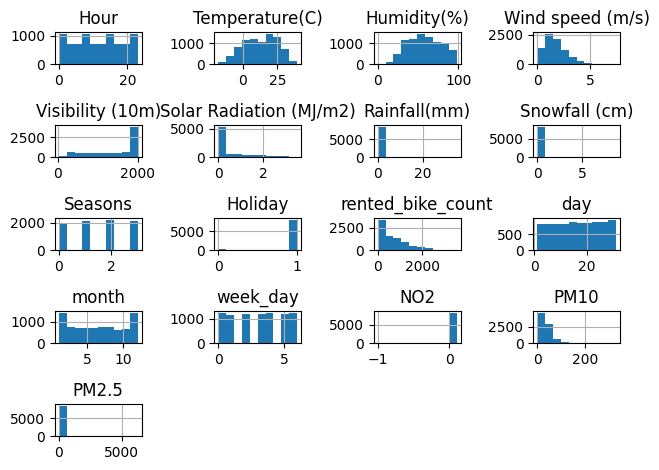

In [49]:
# Plot histograms for initial view of distribution
df.hist()
plt.tight_layout()

In [50]:
# Function for plotting hist, line, box for data fixing

def plotvar(df,var):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  df[var].hist(bins=50)

  plt.subplot(1,3,2)
  stats.probplot(df[var], dist='norm',plot=plt)

  plt.subplot(1,3,3)
  plt.boxplot(df[var],vert=False)

  plt.show()

In [51]:
def transform_and_plot(data, var_name):
    """
    Takes a Pandas DataFrame `data` and the column name `var_name`.
    Applies transformations to reduce skew, then plots the results.

    data: pd.DataFrame
    var_name: str

    """

    # Extract the variable of interest
    x = data[var_name].dropna()

    # Define transformations in a dict
    transformations = {
        "Raw": lambda x: x,
        "Log": np.log,              # requires x > 0
        "Square Root": np.sqrt,     # requires x >= 0
        "Reciprocal": lambda x: 1/x,# requires x != 0
        "Quantile": None,           # handled separately
        "Yeo-Johnson": None         # handled separately
    }

    # Prepare a figure for subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs = axs.flatten()

    # Plot the raw data first
    raw_skew = skew(x)
    sns.histplot(x, kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f"Raw (skew={raw_skew:.2f})")

    # Keep track of subplot indices
    subplot_idx = 1

    # Apply transformations
    for name, func in transformations.items():
        if name == "Raw":
            continue

        if name == "Quantile":
            try:
                qt = QuantileTransformer(output_distribution='normal')
                transformed = qt.fit_transform(x.values.reshape(-1, 1)).squeeze()
            except ValueError as ve:
                axs[subplot_idx].set_title(f"{name} failed: {ve}")
                subplot_idx += 1
                continue
        elif name == "Yeo-Johnson":
            try:
                transformed, _ = yeojohnson(x)
            except ValueError as ve:
                axs[subplot_idx].set_title(f"{name} failed: {ve}")
                subplot_idx += 1
                continue
        else:
            # Apply standard transformations
            try:
                transformed = func(x)
            except ValueError as ve:
                axs[subplot_idx].set_title(f"{name} failed: {ve}")
                subplot_idx += 1
                continue

        current_skew = skew(transformed)
        sns.histplot(transformed, kde=True, ax=axs[subplot_idx], color='skyblue')
        axs[subplot_idx].set_title(f"{name} (skew={current_skew:.2f})")
        subplot_idx += 1

    plt.tight_layout()
    plt.show()

# Handling temperature

Temperature looks acceptable, and the skewness and kurtosis were within normal range. Leave as it is.

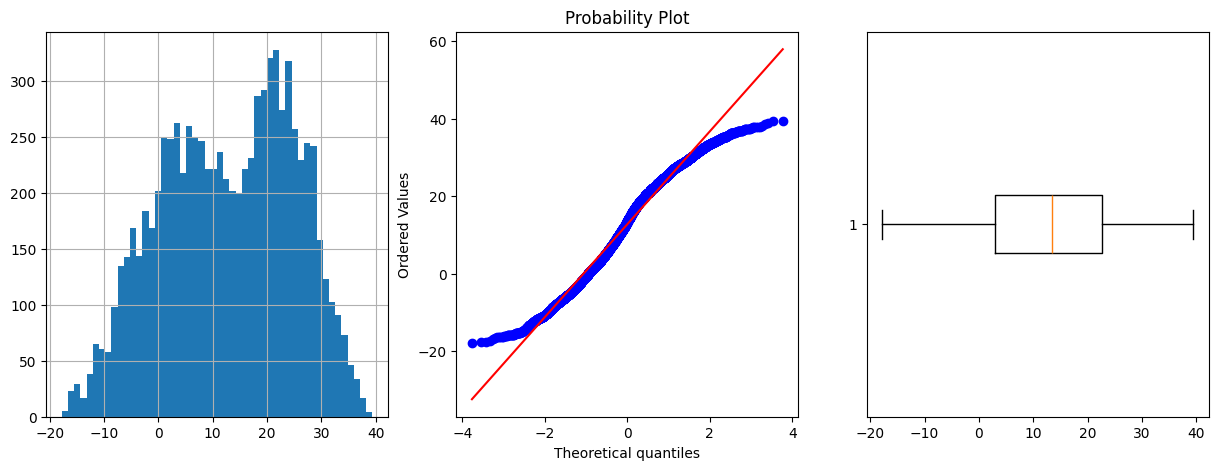

In [52]:
plotvar(df,'Temperature(C)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


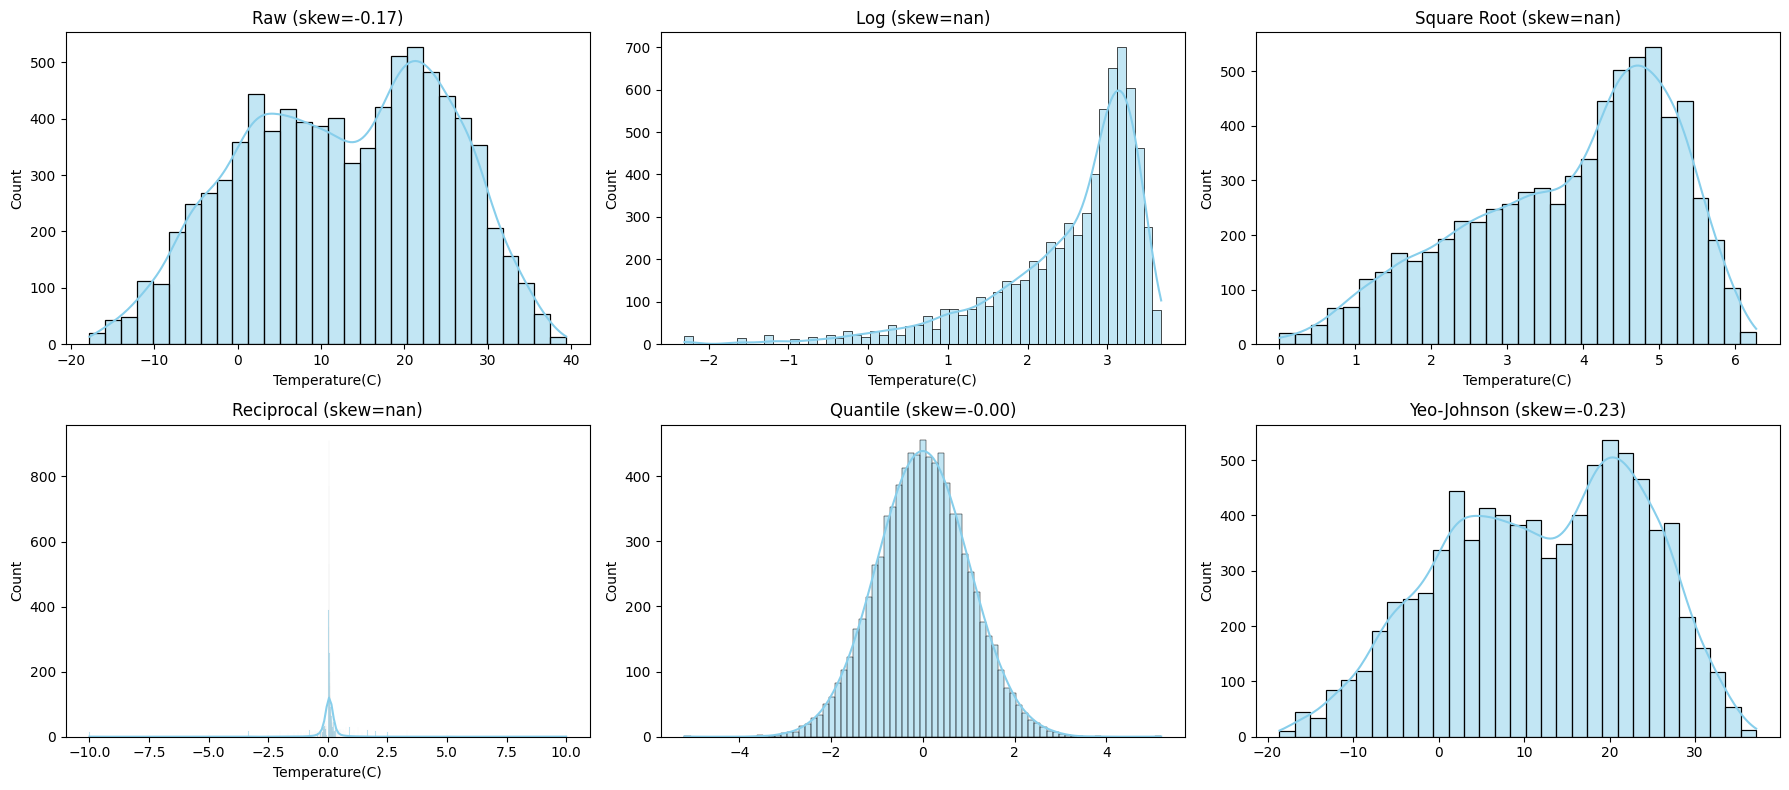

In [53]:
transform_and_plot(df, "Temperature(C)")

# Handling humidity

Humidity also looks broadly fine.

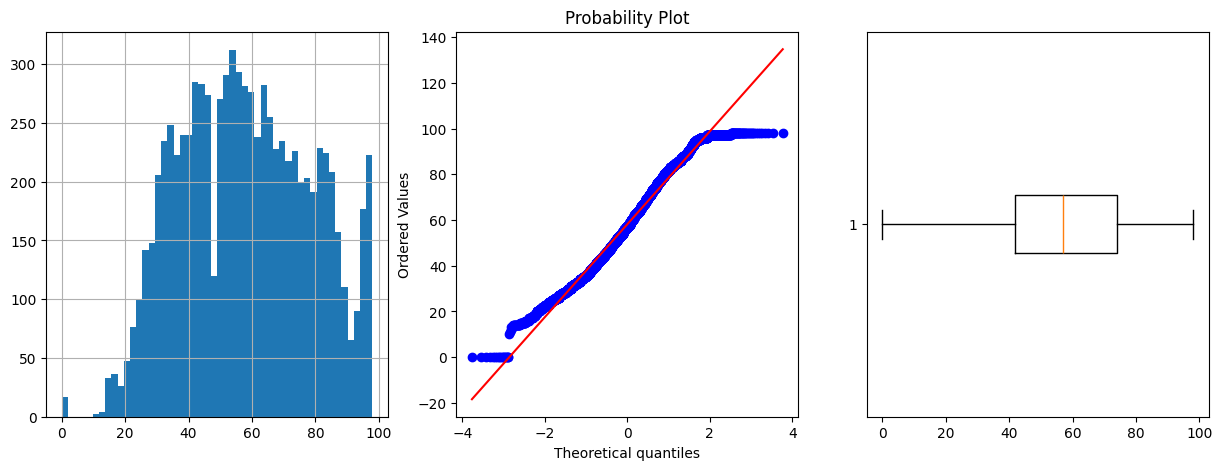

In [54]:
plotvar(df,'Humidity(%)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


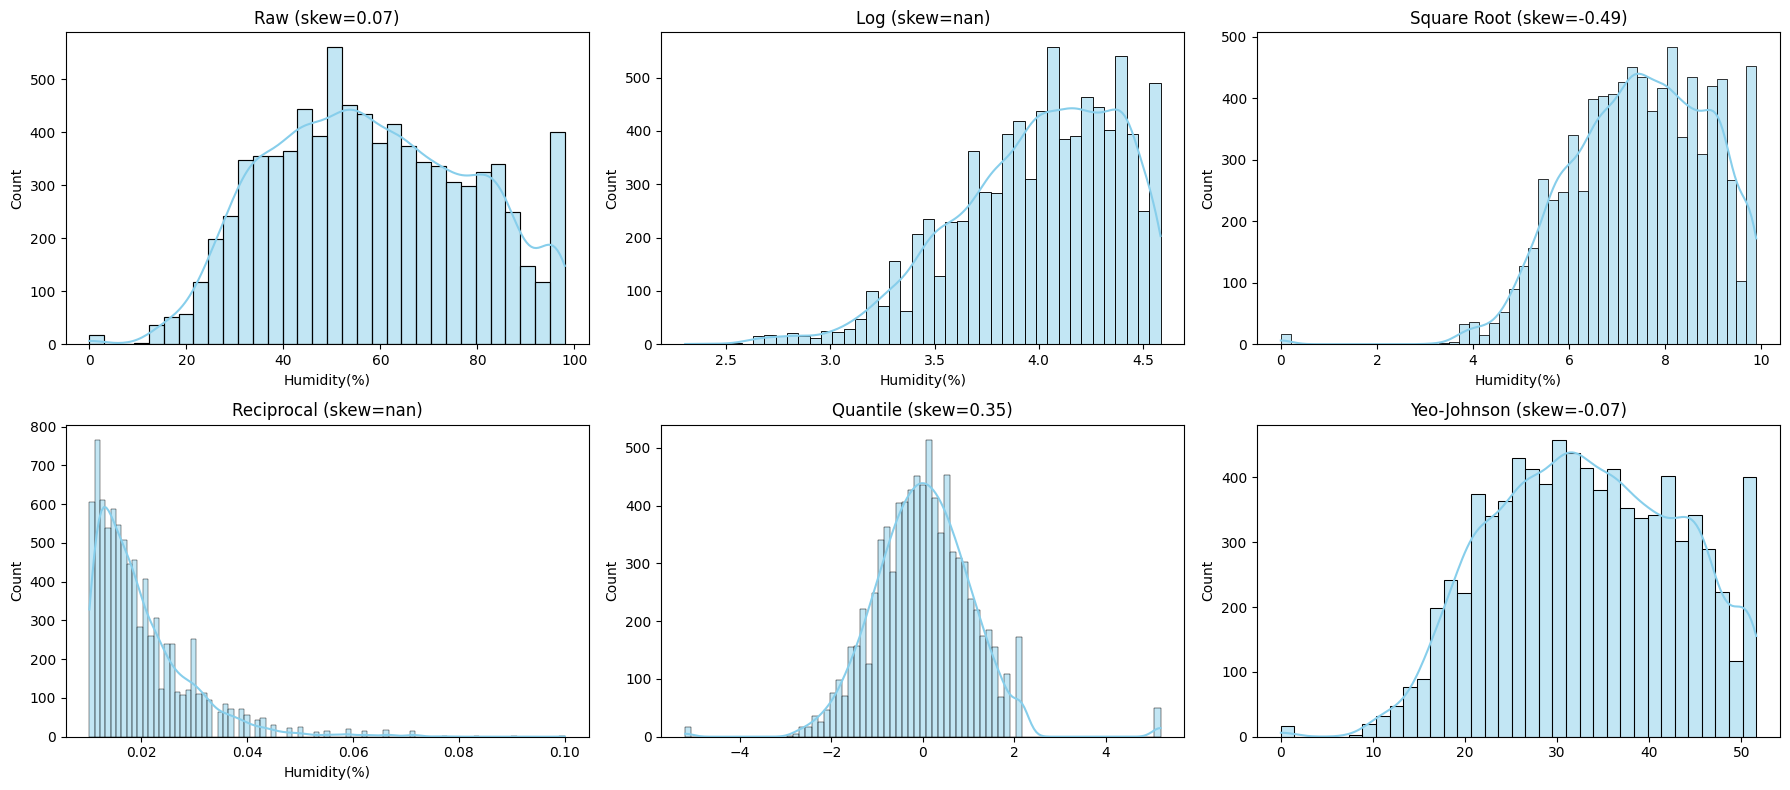

In [55]:
transform_and_plot(df, "Humidity(%)")

# Handling wind speed

Wind speed has some positive skew, so this will need to be adjusted.

Square root transformation.

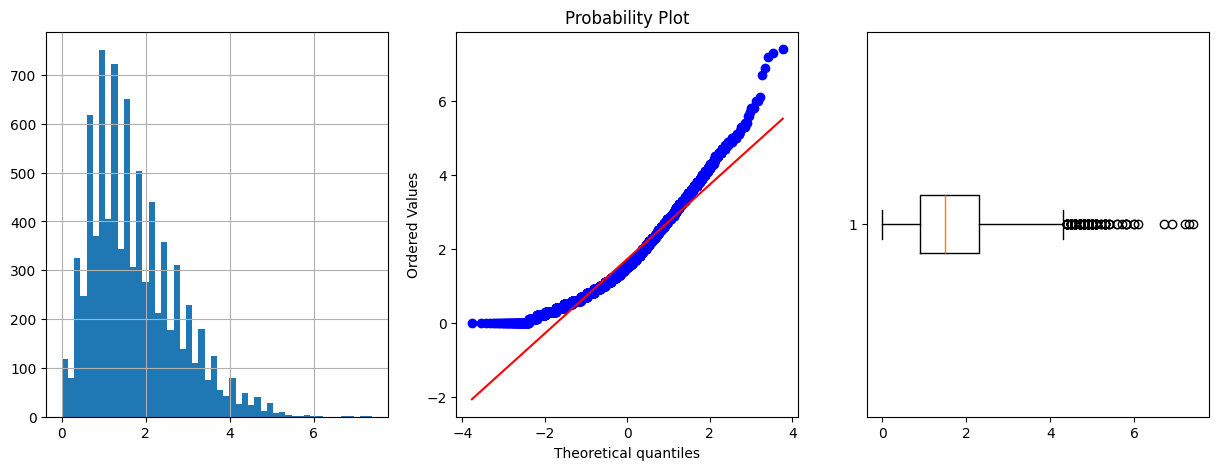

In [56]:
plotvar(df,'Wind speed (m/s)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


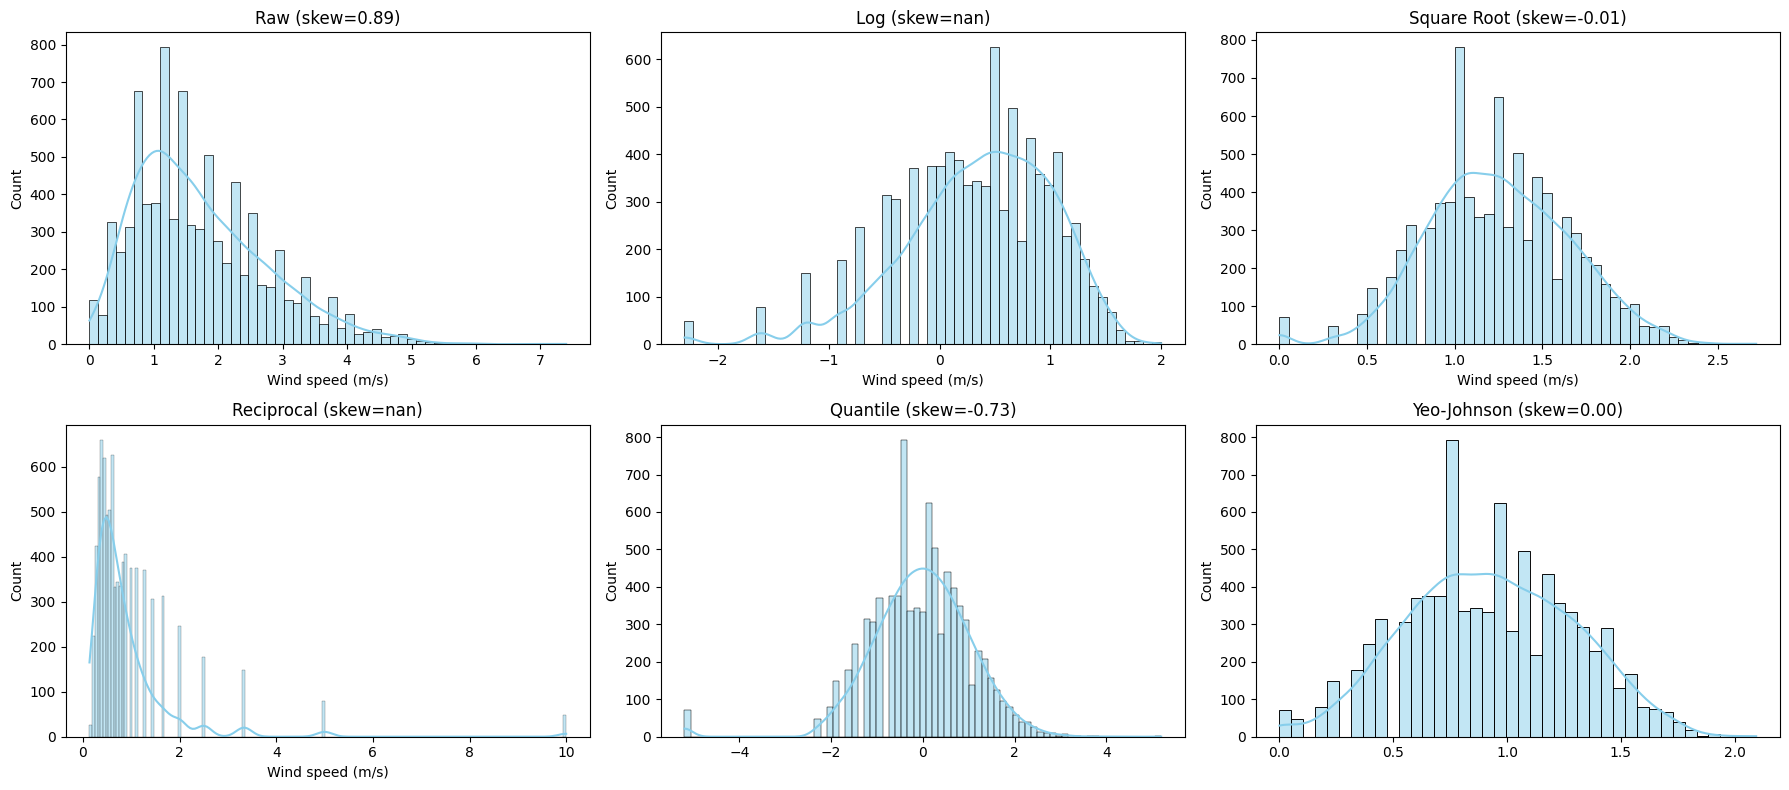

In [57]:
transform_and_plot(df, "Wind speed (m/s)")

# Handling visibility

Two things going on here: negative skew, and a huge number of observations at or close to total visibility (2000).

Two things need to be done:

1. Create additional variable: visibility issues (yes/no)

2. Transform negative skew by reflecting then using quantile transformation

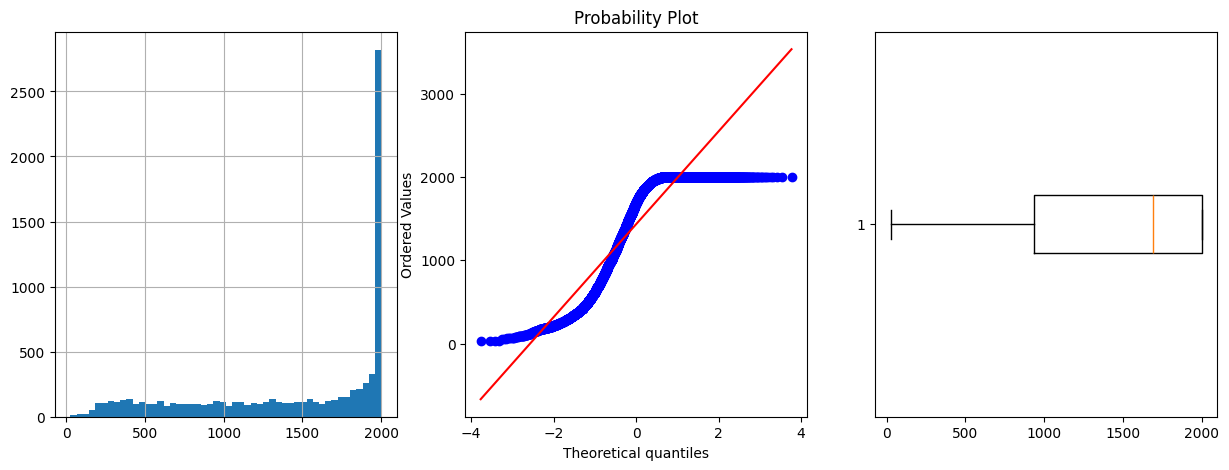

In [58]:
plotvar(df,'Visibility (10m)')

In [82]:
df['Visibility (10m)'].value_counts().head(10)

,count
Visibility (10m),
2000,2150
1995,32
1989,27
1985,27
1996,27
1999,26
1998,24
1992,24
1981,23


In [59]:
# This ensures all values are positive after reflection
df["Visibility_reflect"] = df["Visibility (10m)"].max() + 1 - df["Visibility (10m)"]

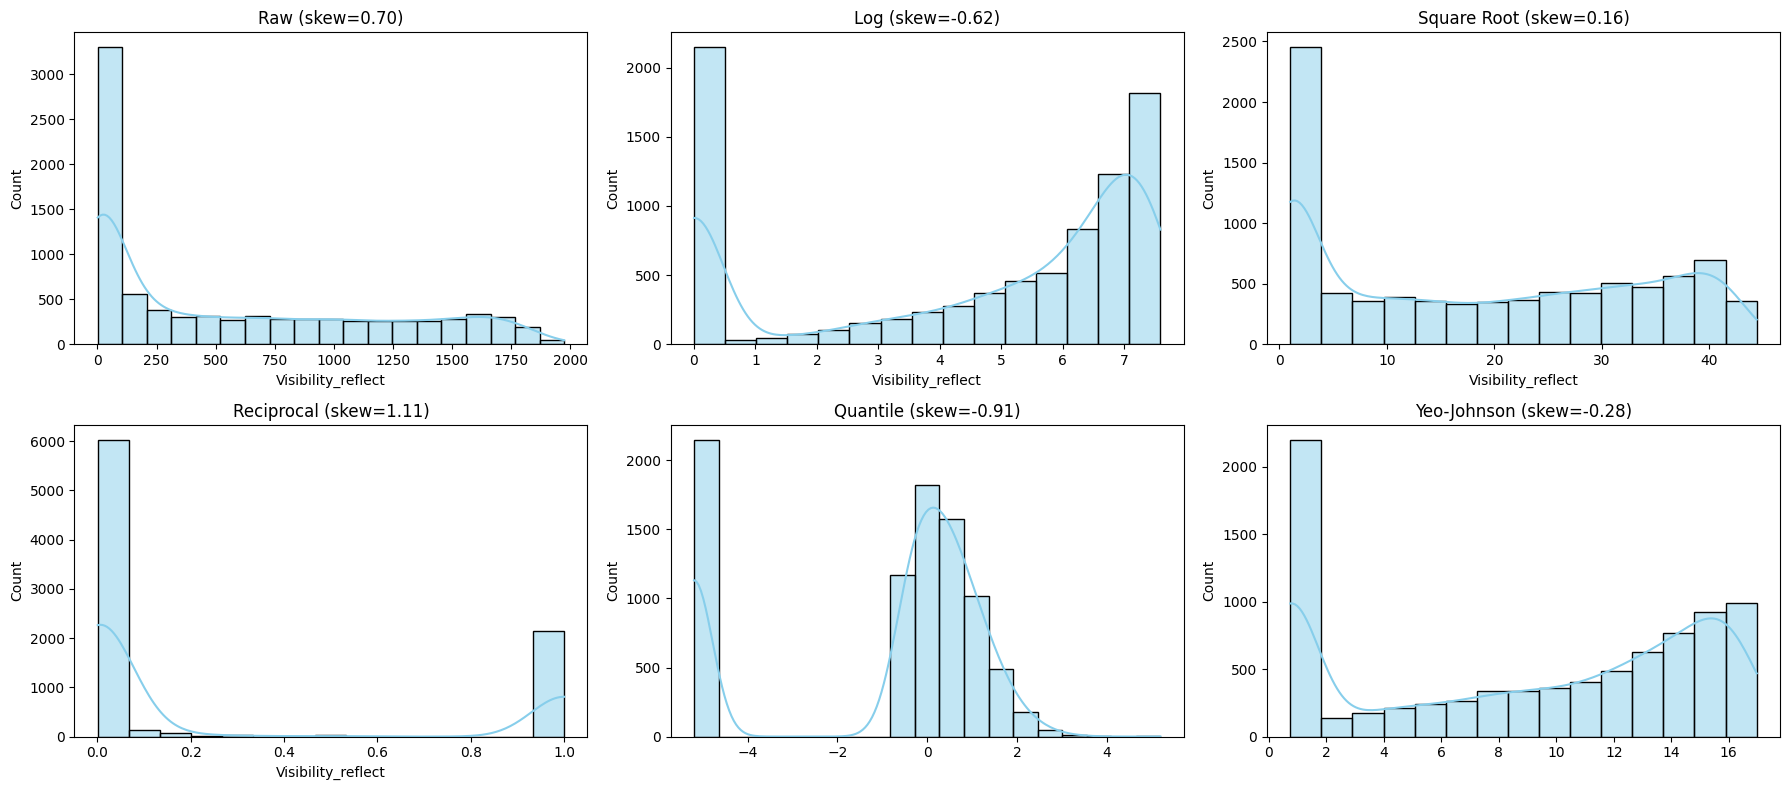

In [60]:
transform_and_plot(df, "Visibility_reflect")

# Handling solar radiation

Lots of observations at 0. Two steps:

1. Create additional variable: solar radiation (yes/no)
2. Transform by using quantile transformation

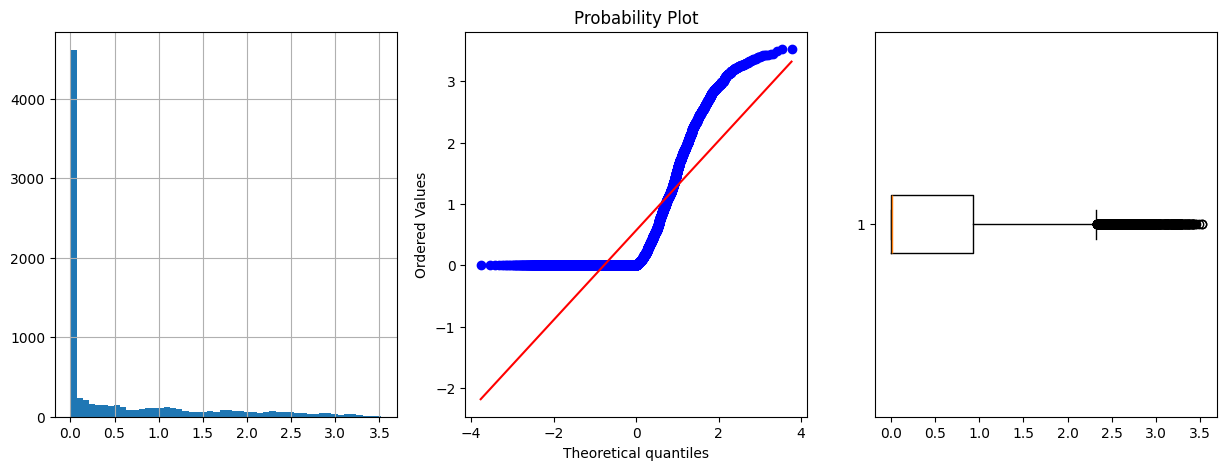

In [61]:
plotvar(df,'Solar Radiation (MJ/m2)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


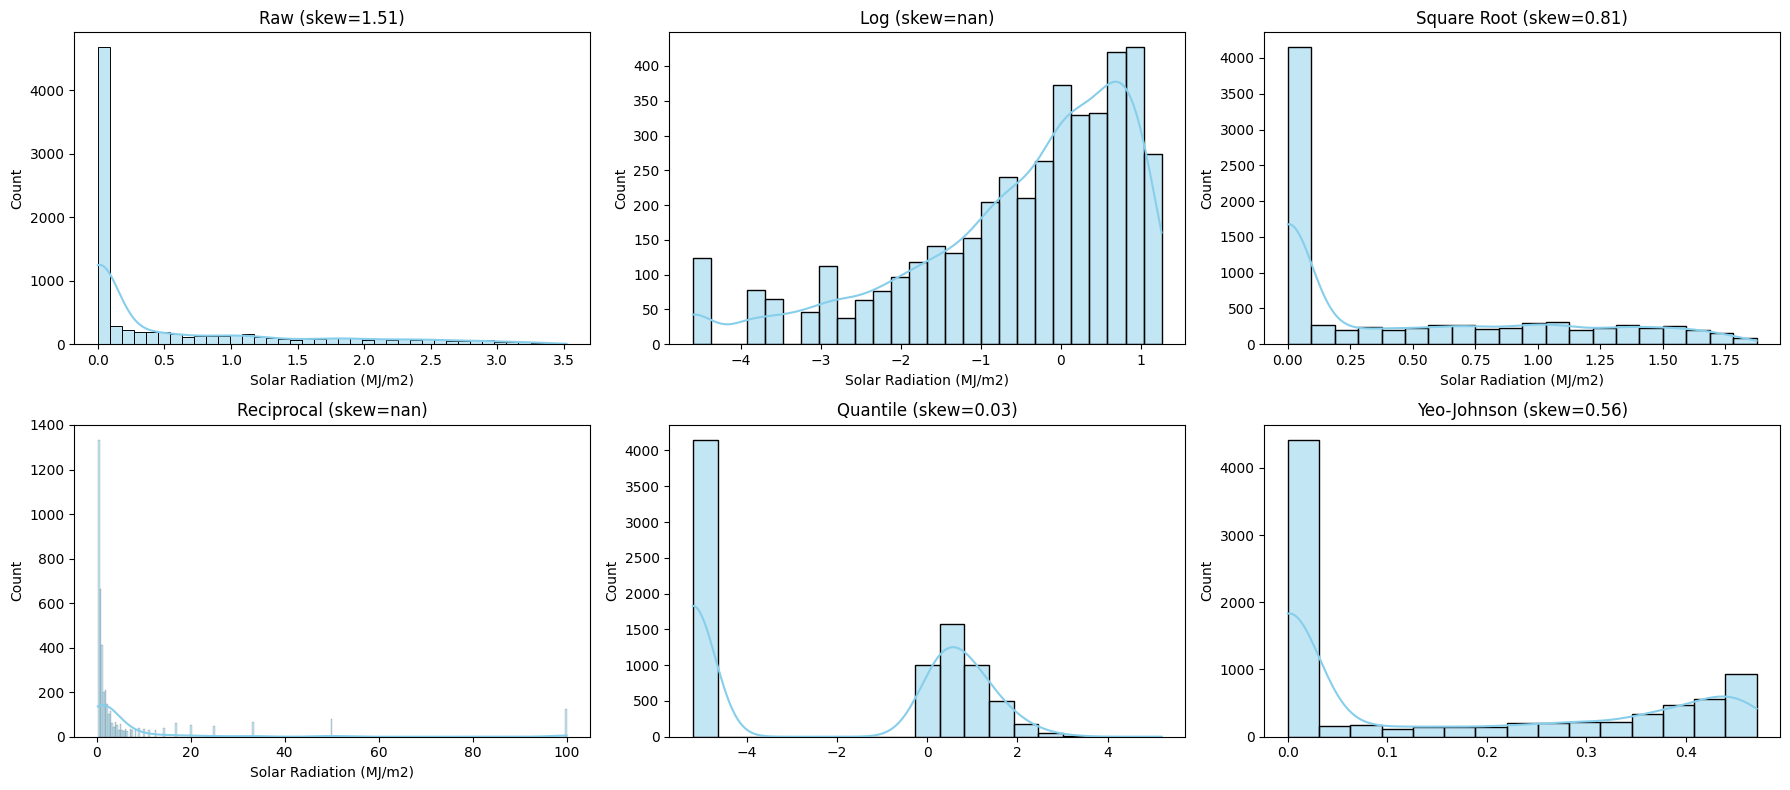

In [62]:
transform_and_plot(df, "Solar Radiation (MJ/m2)")

# Handling rainfall

Lots of observations at 0. Two steps:

1. Create additional variable: rainfall (yes/no)
2. Adjust rain volume's positive skew using log

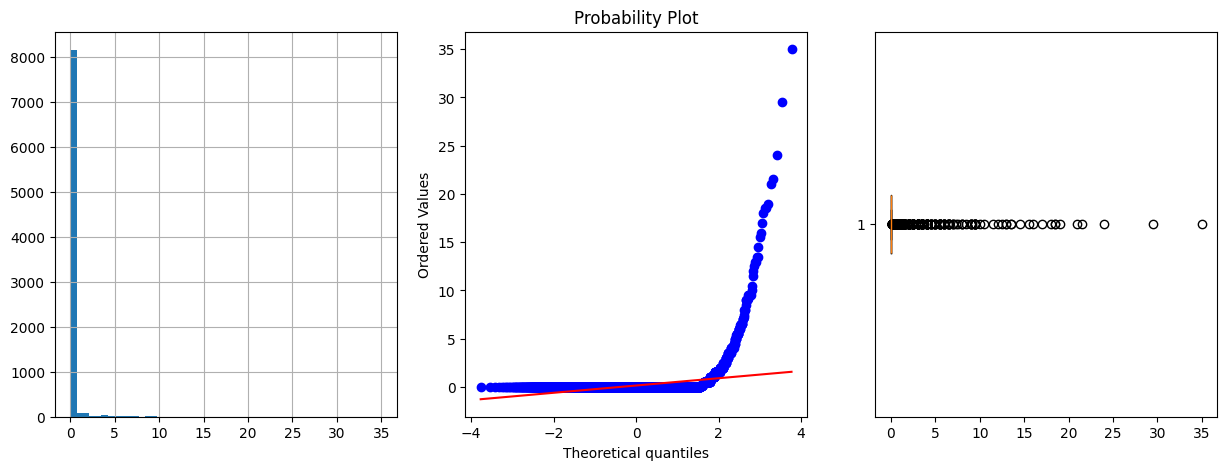

In [63]:
plotvar(df,'Rainfall(mm)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


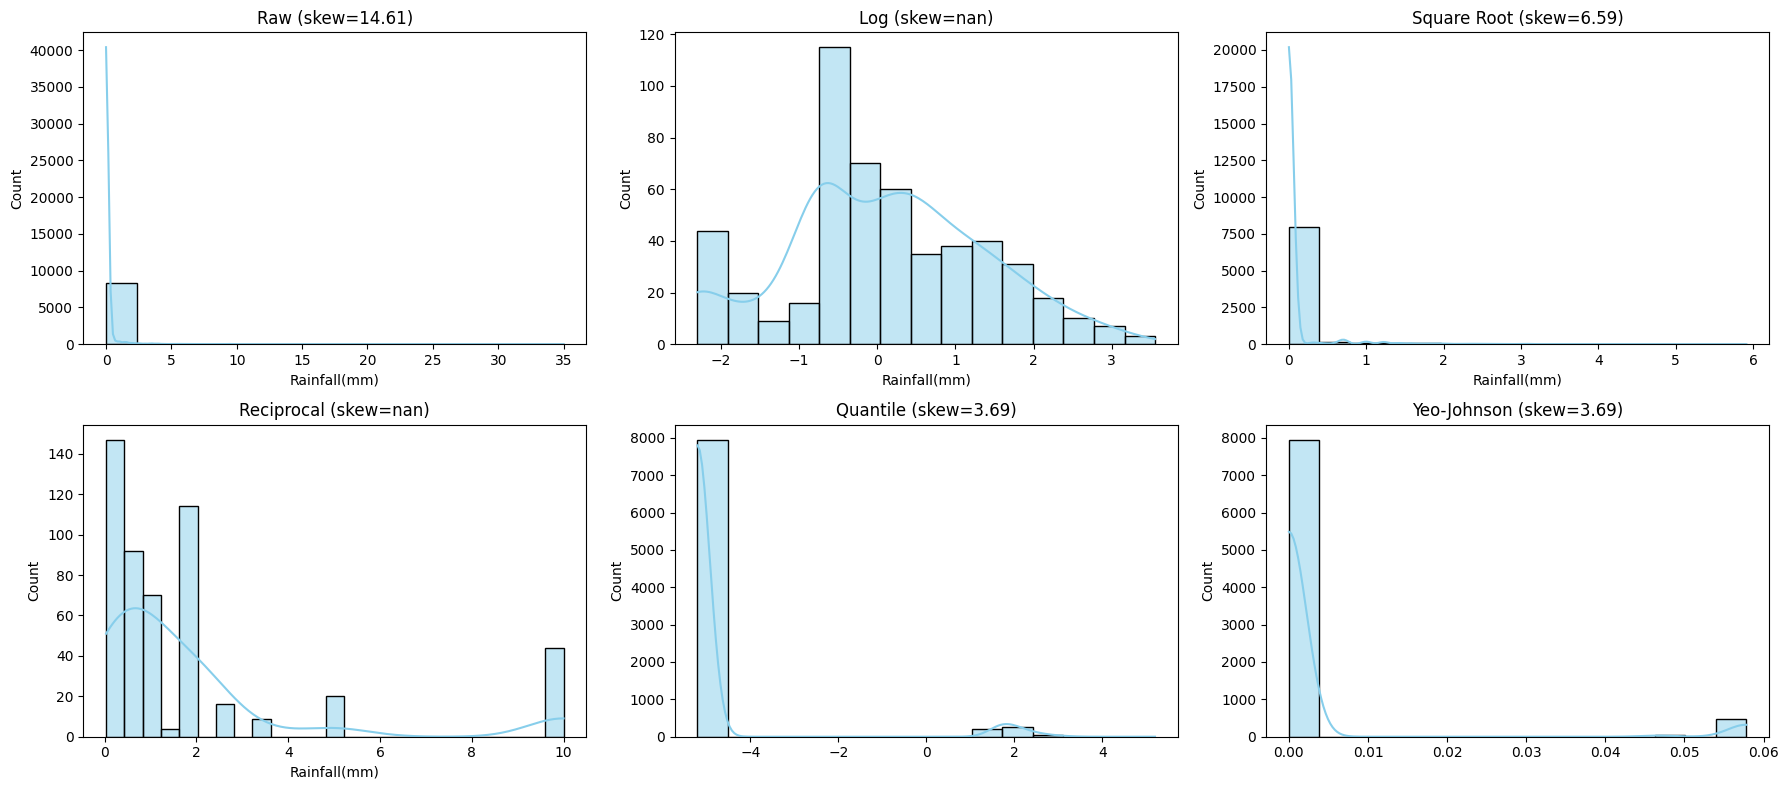

In [64]:
transform_and_plot(df, "Rainfall(mm)")

# Handling snowfall

Lots of observations at 0. Two steps:

1. Create additional variable: snowfall (yes/no)
2. Adjust snow volume's skew using log

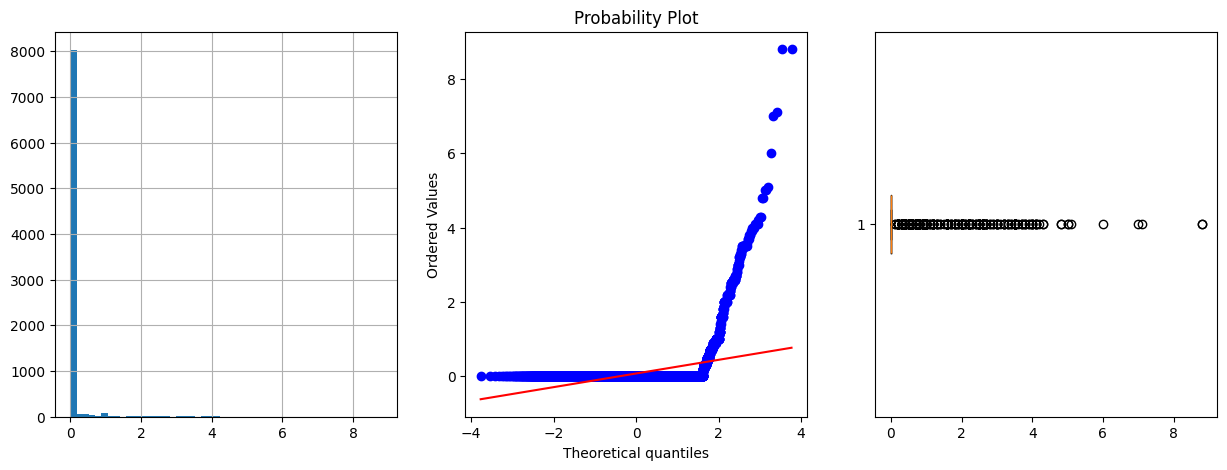

In [65]:
plotvar(df,'Snowfall (cm)')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


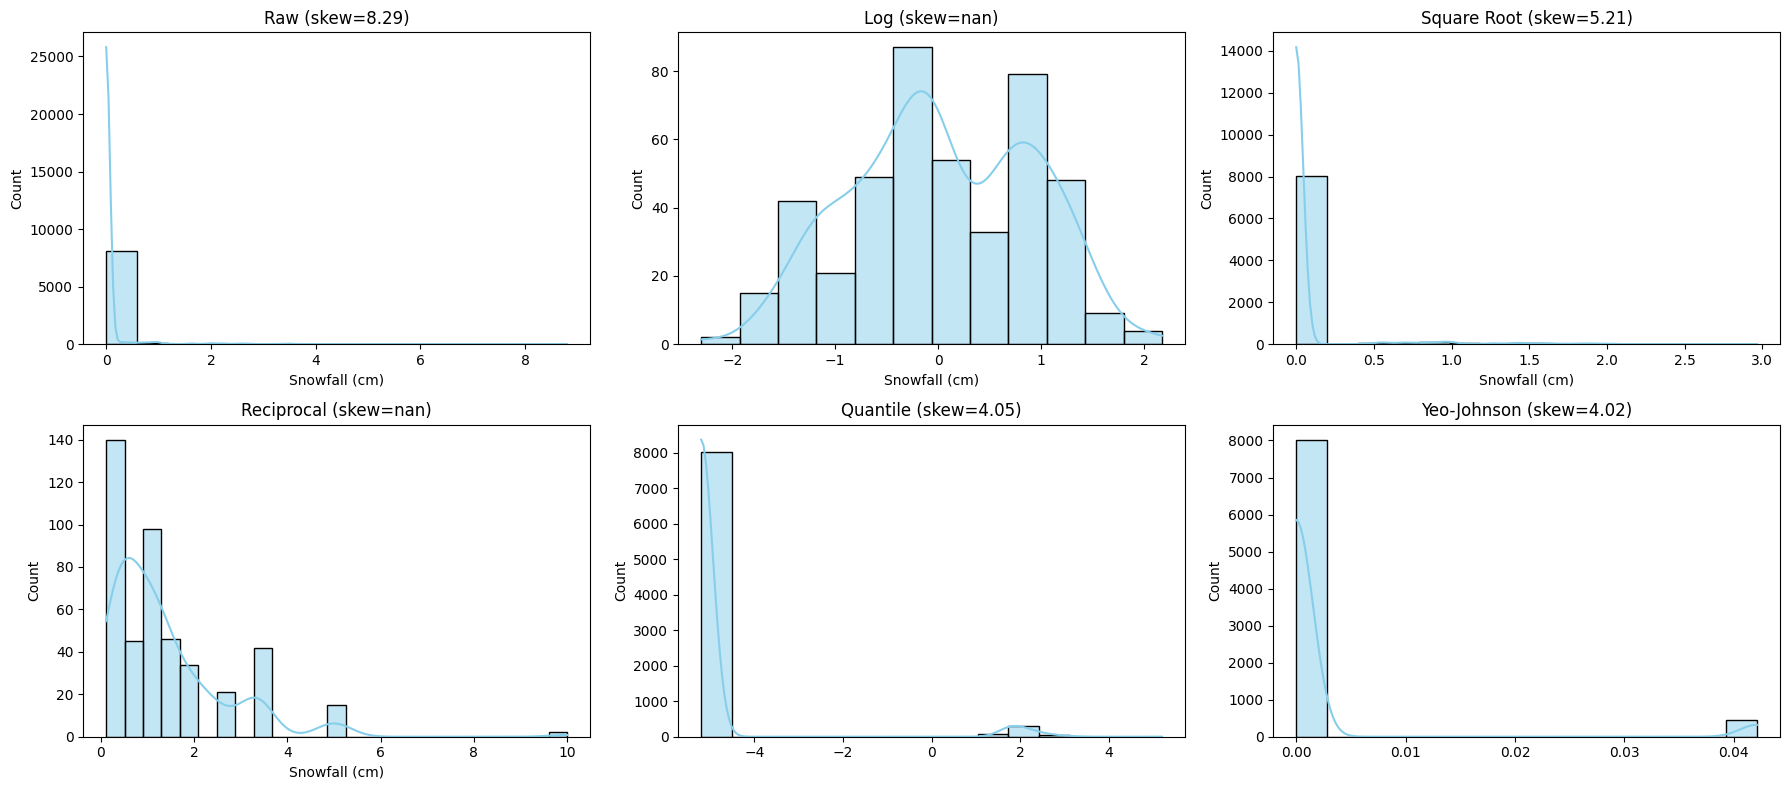

In [66]:
transform_and_plot(df, "Snowfall (cm)")

# Handling rented bike count

Apply yeo-johnson to address positive skew.

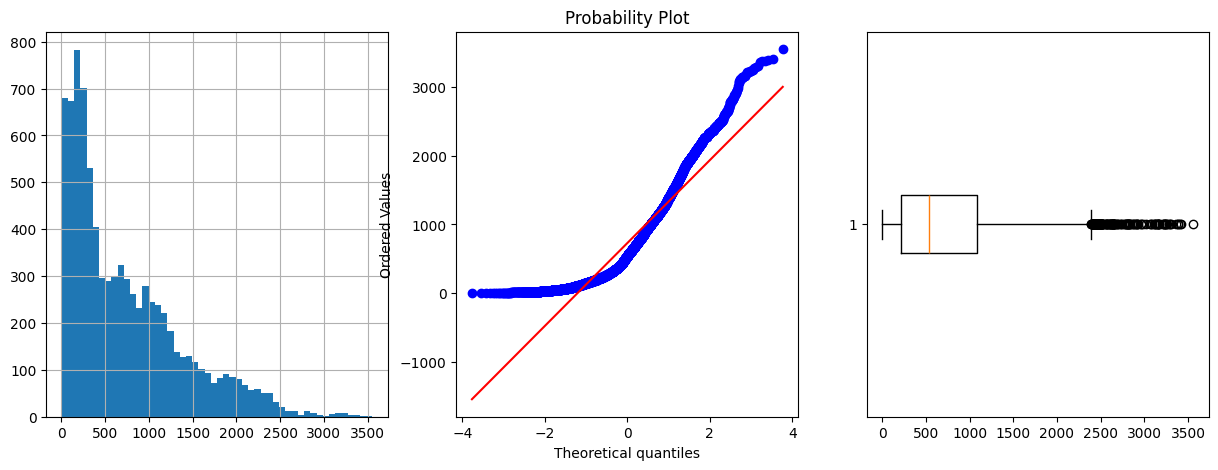

In [67]:
plotvar(df,'rented_bike_count')

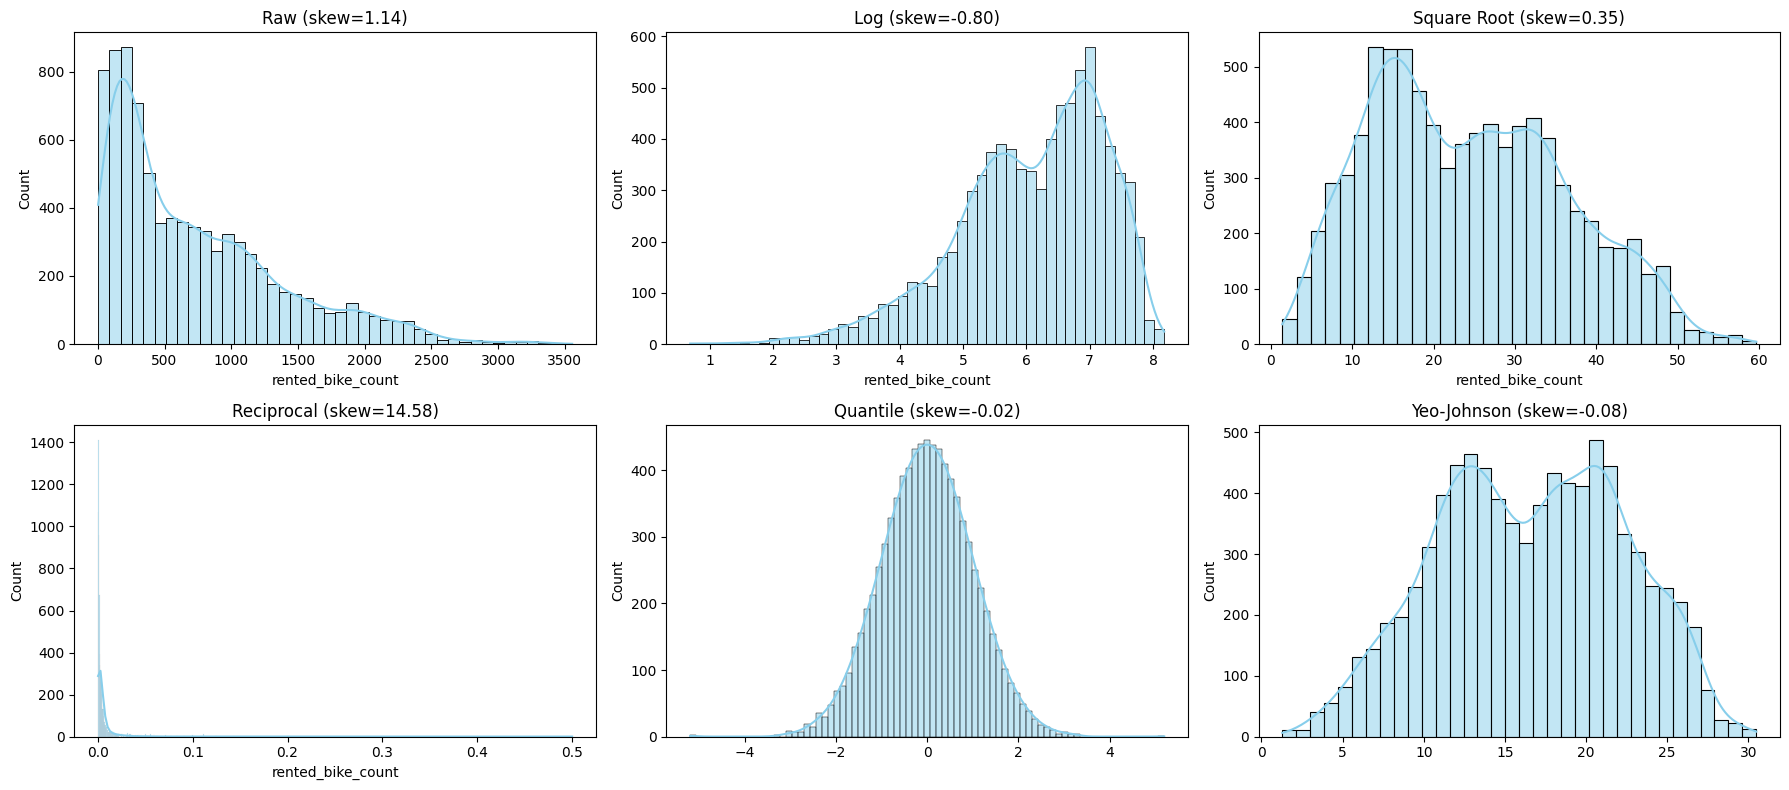

In [68]:
transform_and_plot(df, "rented_bike_count")

# Handling NO2

Looks like error outlier of -1. Delete outlier (replace with mean)

Square root to fix positive skew.

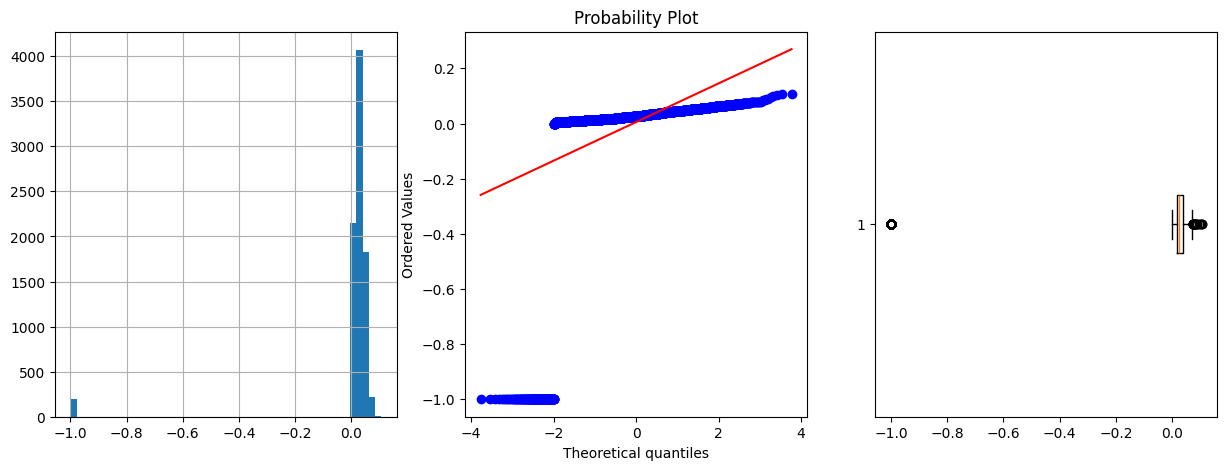

In [69]:
plotvar(df,'NO2')

In [70]:
neg_value_counts = df.loc[df['NO2'] < 0, 'NO2'].value_counts()
print(neg_value_counts)

NO2
-1.0    196
Name: count, dtype: int64


In [71]:
# Calculate the mean of NO2, excluding any rows where NO2 == -1.0
mean_no2_excl_neg1 = df.loc[df['NO2'] != -1.0, 'NO2'].mean()

# Replace -1.0 values with that mean
df.loc[df['NO2'] == -1.0, 'NO2'] = mean_no2_excl_neg1

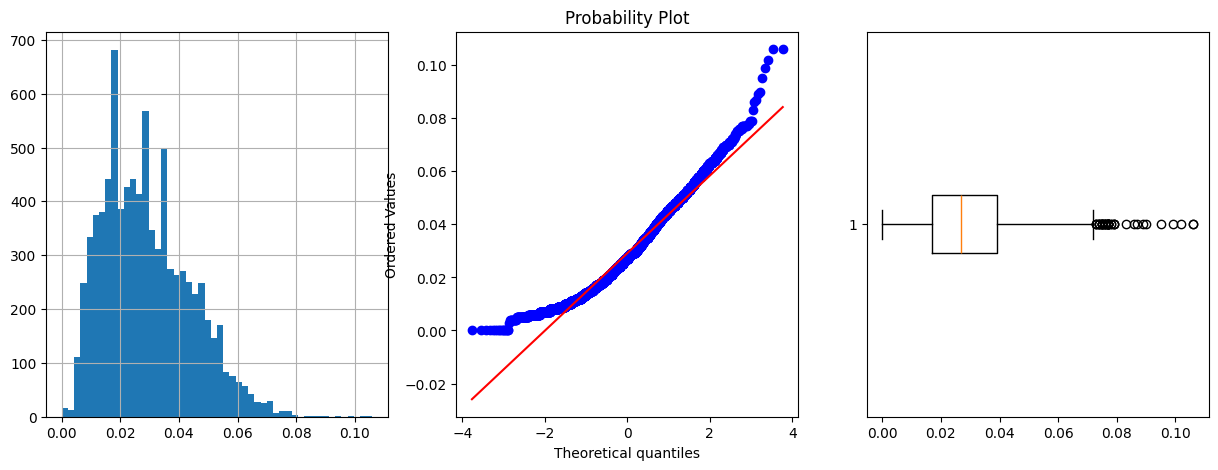

In [72]:
plotvar(df,'NO2')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


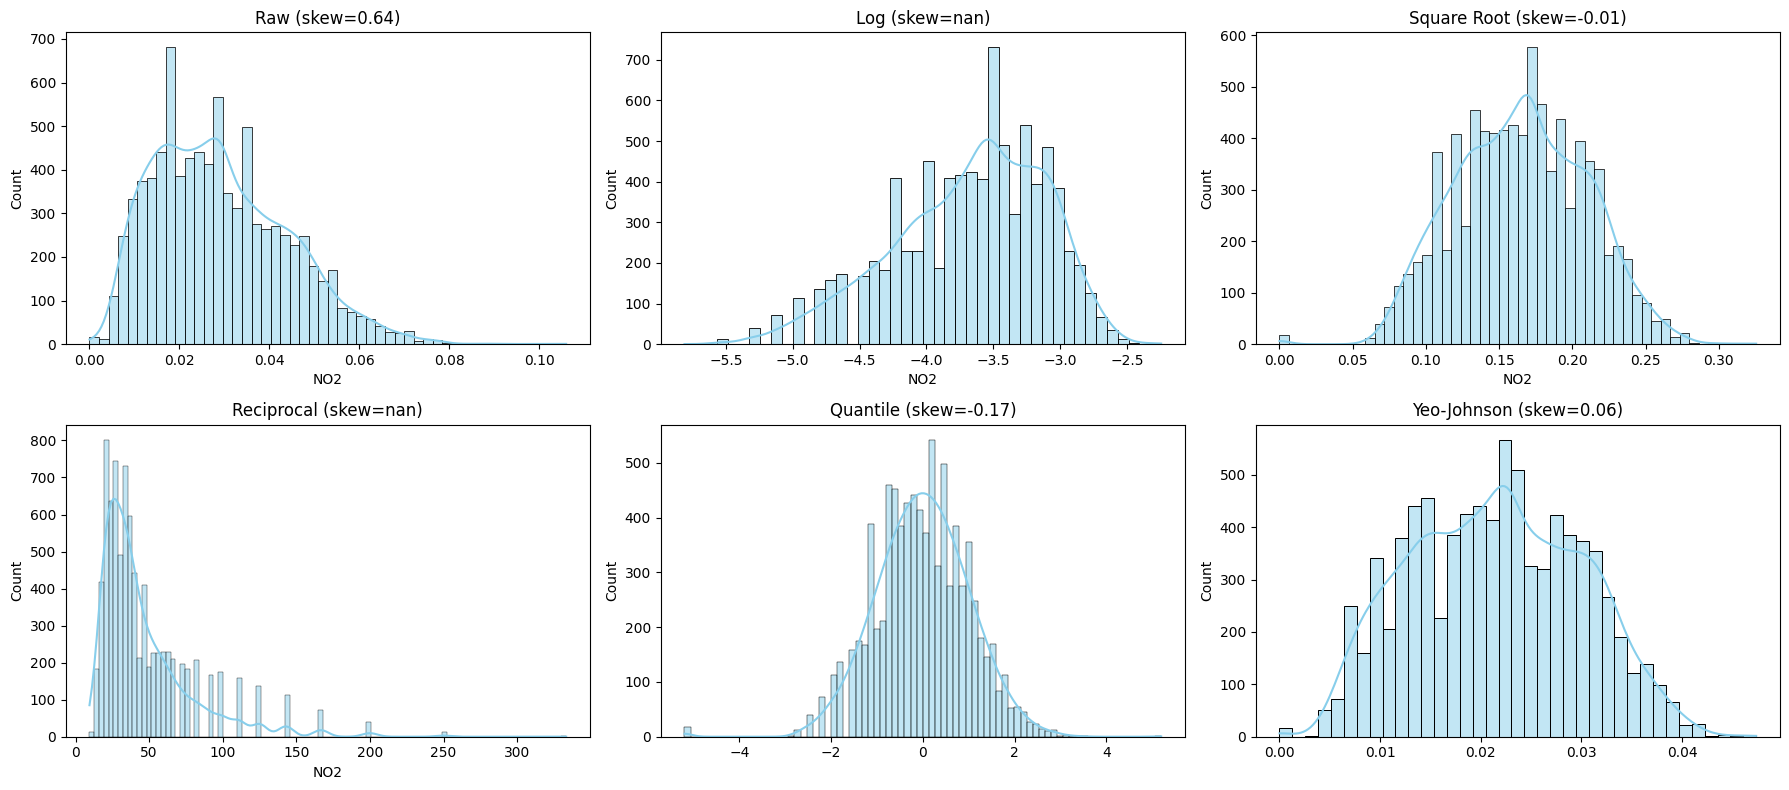

In [73]:
transform_and_plot(df, "NO2")

# Handling PM10

Apply yeo-johnson to fix aggressive positive skew.

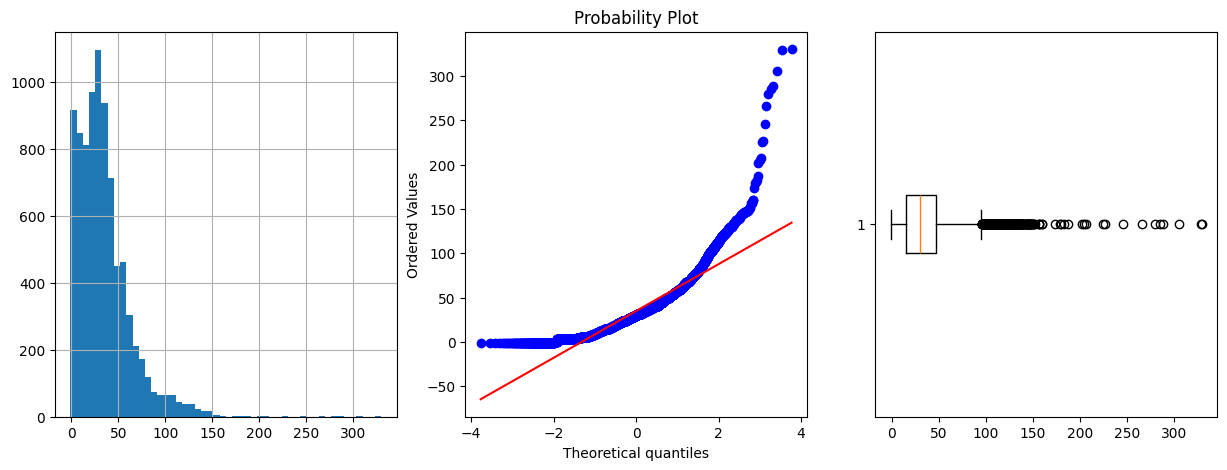

In [74]:
plotvar(df,'PM10')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


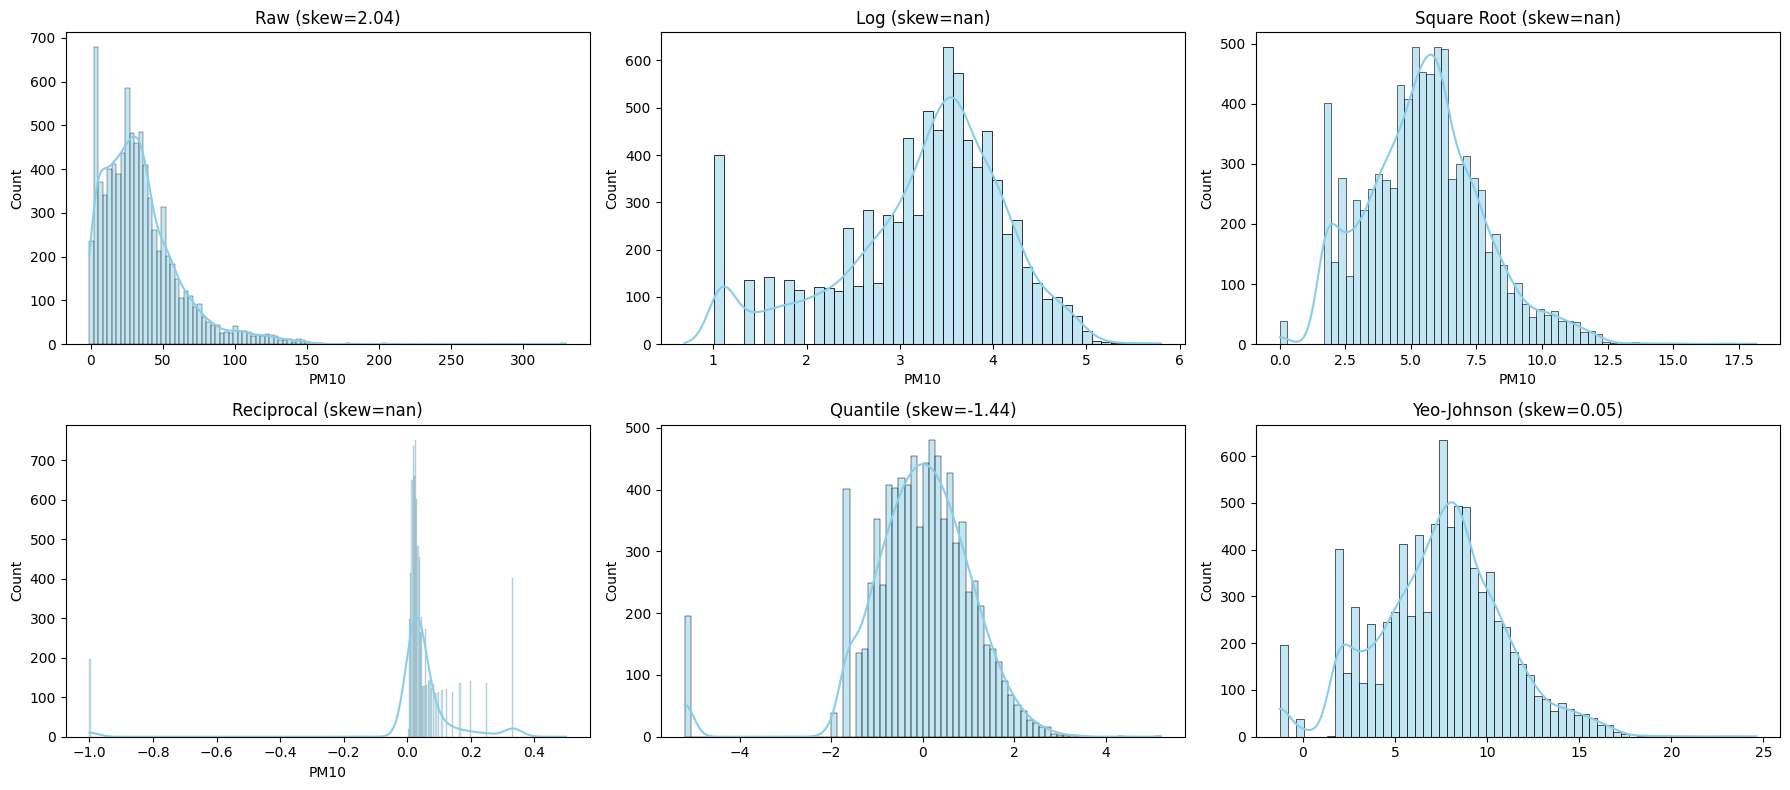

In [75]:
transform_and_plot(df, "PM10")

# Handling PM2.5

Looks like a huge outlier at 6000. Delete outlier, then investigate and handle skew.

Yeo-johnson to handle skew.

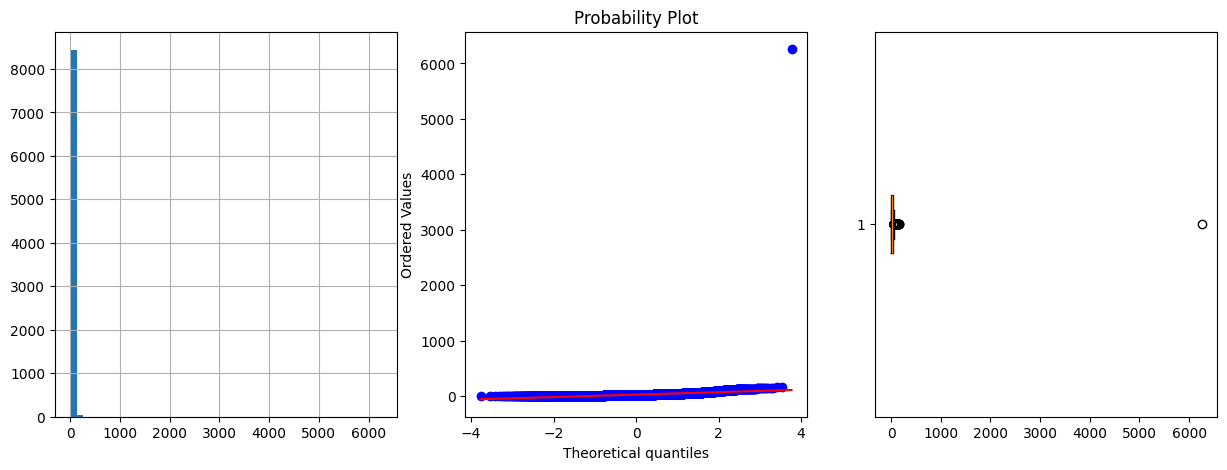

In [76]:
plotvar(df,'PM2.5')

In [77]:
# Filter PM2.5 values over 6000
outliers = df.loc[df['PM2.5'] > 6000, 'PM2.5']

# Print how many outliers
print(f"Number of outliers > 6000: {outliers.shape[0]}")

# Print each unique outlier value with counts
outlier_counts = outliers.value_counts()
print("Outlier values and their counts:")
print(outlier_counts)

Number of outliers > 6000: 1
Outlier values and their counts:
PM2.5
6256.0    1
Name: count, dtype: int64


In [78]:
# drop the row with the single outlier
df = df.drop(df.loc[df['PM2.5'] == 6256.0].index)

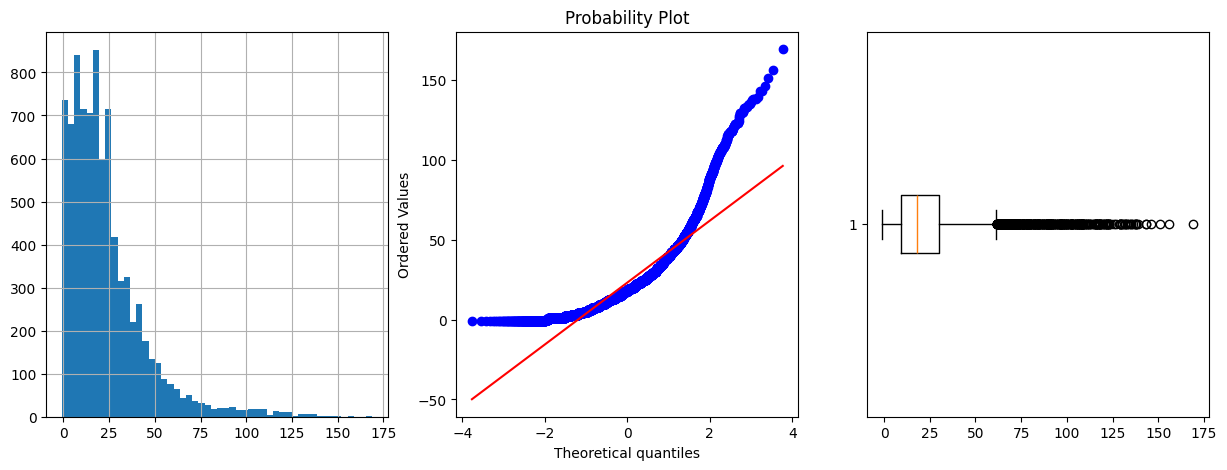

In [79]:
plotvar(df,'PM2.5')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


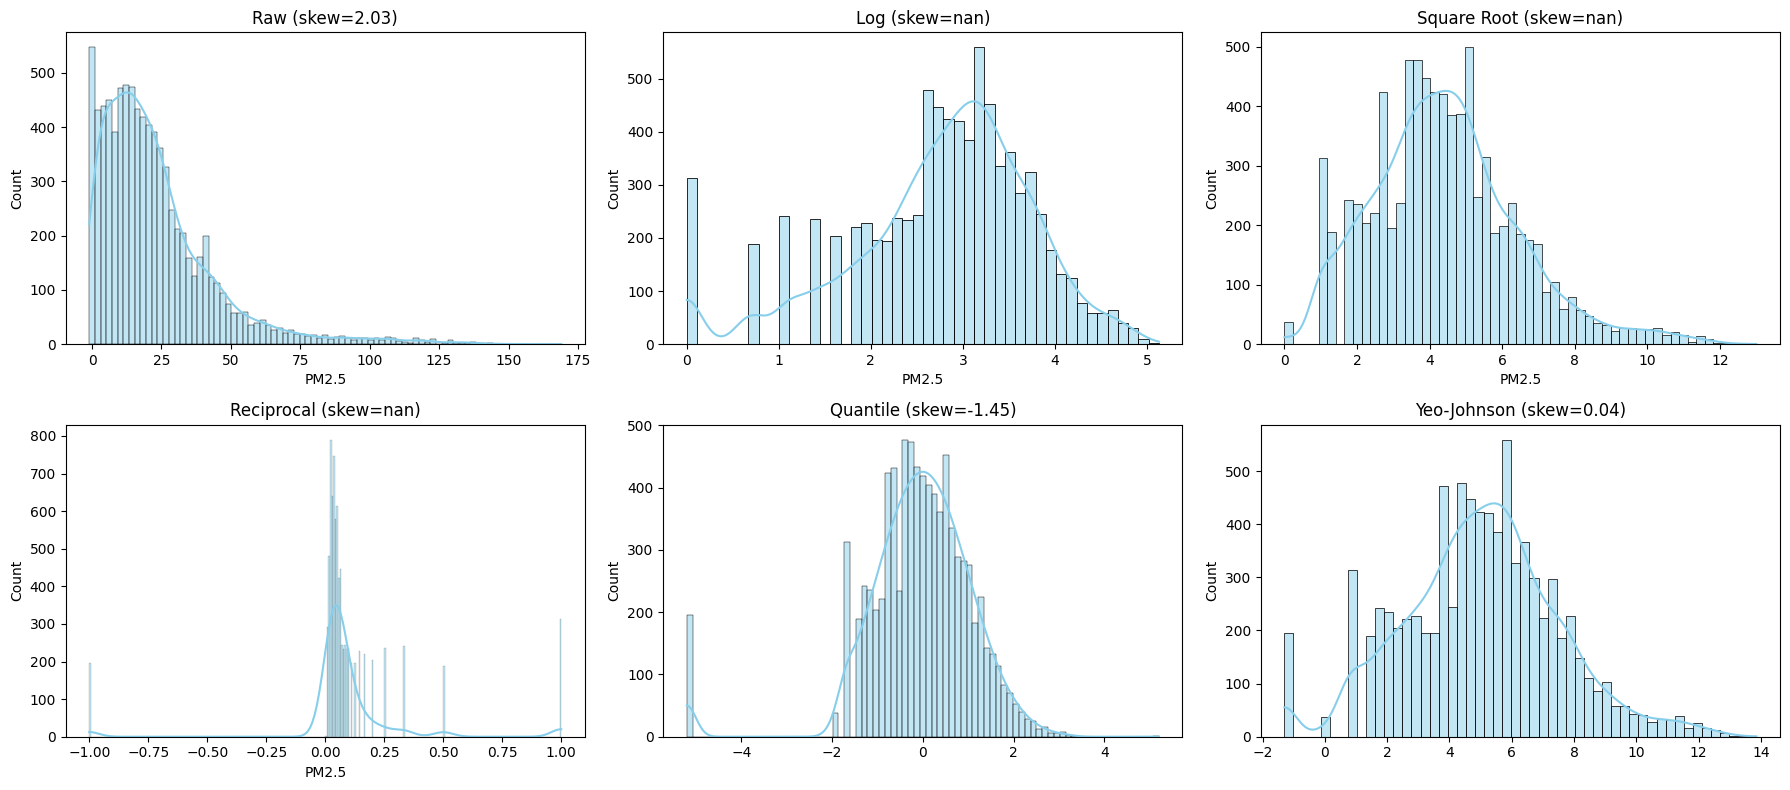

In [80]:
transform_and_plot(df, "PM2.5")

# Creating a joblib pipeline tool & export

In [86]:
# 1) Custom Transformer to create/modify columns before they go into the main ColumnTransformer
class CustomFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Visibility
        X["visibility_issues"] = np.where(X["Visibility (10m)"] == 2000, 0, 1)
        max_vis = X["Visibility (10m)"].max()
        X["Visibility (10m)"] = max_vis - X["Visibility (10m)"]  # reflect

        # Solar Radiation
        X["any_radiation"] = np.where(X["Solar Radiation (MJ/m2)"] == 0, 0, 1)

        # Rainfall
        X["raining"] = np.where(X["Rainfall(mm)"] == 0, 0, 1)

        # Snowfall
        X["snowing"] = np.where(X["Snowfall (cm)"] == 0, 0, 1)

        return X

# 2) Define helper transformation functions
def sqrt_transform(x):
    # Clip to make sure values are >= 0
    return np.sqrt(np.clip(x, a_min=0, a_max=None))

def log_transform(x):
    # log1p handles zero by doing log(1 + x)
    return np.log1p(np.clip(x, a_min=0, a_max=None))

# 3) Specify which columns go through which transformations
categorical_cols = ["Hour", "Seasons", "Holiday", "day", "month", "week_day"]
no_transform_cols = ["Temperature(C)", "Humidity(%)"]
sqrt_cols = ["Wind speed (m/s)", "NO2"]
yeo_cols = ["rented_bike_count", "PM10", "PM2.5"]
log_cols = ["Rainfall(mm)", "Snowfall (cm)"]
quantile_cols_visibility = ["Visibility (10m)"]
quantile_cols_solar = ["Solar Radiation (MJ/m2)"]

# Binary columns added in the custom step that we want to keep
binary_cols = ["visibility_issues", "any_radiation", "raining", "snowing"]

# 4) Build the ColumnTransformer
#    - Categorical: OneHotEncode
#    - Some numeric columns: passthrough
#    - Others: apply function transformers or scikit-learn’s built-in transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols),
        ("no_transform", "passthrough", no_transform_cols),
        ("sqrt", FunctionTransformer(sqrt_transform), sqrt_cols),
        ("log", FunctionTransformer(log_transform), log_cols),
        ("yeo", PowerTransformer(method='yeo-johnson'), yeo_cols),
        ("quantile_visibility", QuantileTransformer(output_distribution='normal'), quantile_cols_visibility),
        ("quantile_solar", QuantileTransformer(output_distribution='normal'), quantile_cols_solar),
        ("binary", "passthrough", binary_cols)
    ],
    remainder='drop'  # drop anything else not specified
)

# 5) Build the full pipeline:
#    a) Add the custom feature engineering step
#    b) Apply the ColumnTransformer
#    c) Finally, scale all numeric outputs with MinMaxScaler
pipeline = Pipeline([
    ("custom_features", CustomFeatures()),
    ("transform", preprocessor),
    ("scaler", MinMaxScaler())
])


# Save the pipeline to your 'models' folder
# dump(pipeline, "models/pipeline.joblib")




In [89]:
# Transform the df into numpy array, then convert array to pandas df
transformed_array = pipeline.fit_transform(df)
df_transformed = pd.DataFrame(transformed_array)

In [90]:
df_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.400169,0.265666,0.315959,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.367228,0.279586,0.343016,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.343742,0.250814,0.367232,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.281107,0.279586,0.367232,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.244252,0.234835,0.285038,0.0,0.0,0.0,0.0,0.0,0.0


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>],
       [<Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>,
        <Axes: title={'center': '13'}>, <Axes: title={'center': '14'}>,
        <Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>],
       [<Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>,
        <Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>],
       [<Axes: title={'

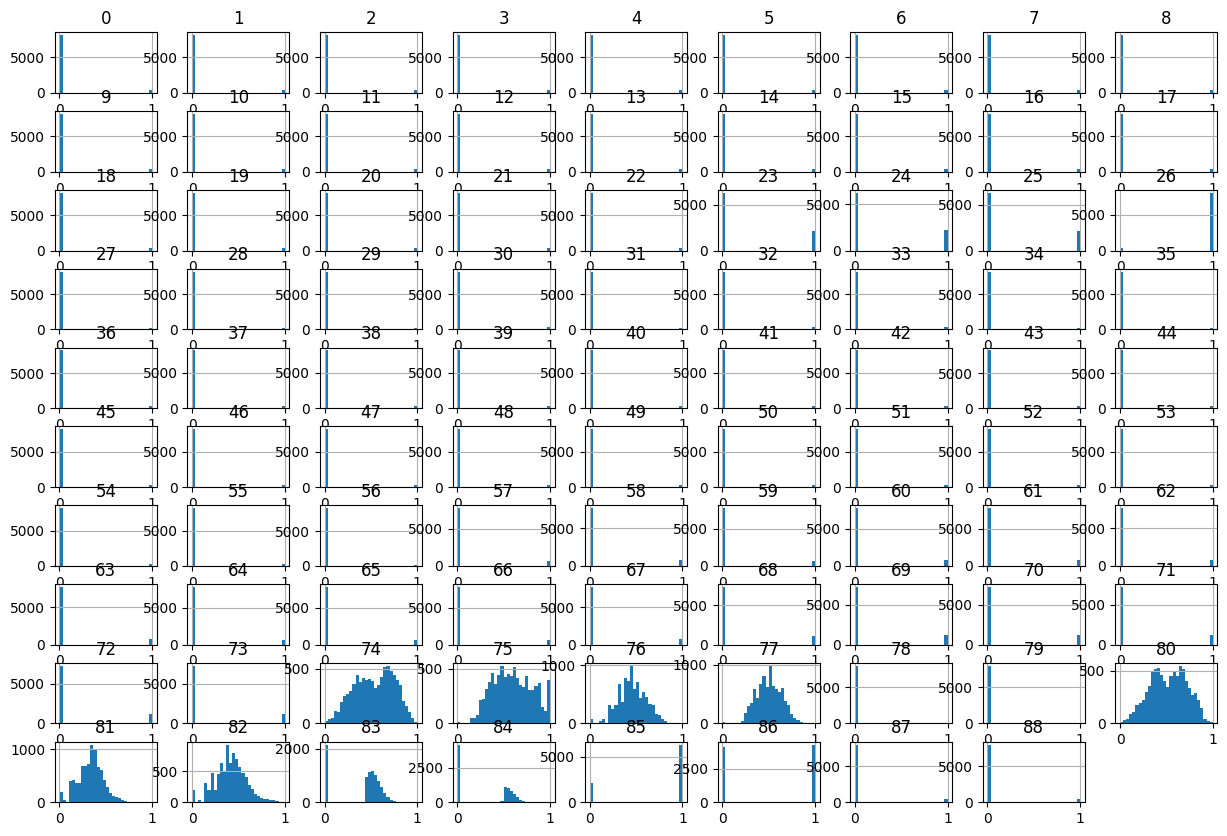

In [98]:
# Quick look at variables before moving on...
df_transformed.hist(bins=30, figsize=(15, 10))

In [93]:
# Save the pipeline to the appropriate folder
dump(pipeline, "bicycles_seoul/models/pipeline.joblib")

['bicycles_seoul/models/pipeline.joblib']

In [94]:
# Save as csv in Drive
df_transformed.to_csv('data/processed/02-processed-for-training.csv', index=False)